# Clustering bible books

 - Grouping bible books using clustering algorithms
 

In [1]:
import os
import re
import string
import traceback
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from nltk import FreqDist, ngrams
from prettytable import PrettyTable
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

# Prepare data

- The data used for minority languages is csv file having verses along with chapter , book info.   Only the verses are taken and saved to txt files. 

In [2]:
cwd = os.getcwd() + '/'
min_languages = ['mandeali', 'haryanvi', 'dogri', 'pahari_mahasui', 'baghlayani', 'chambeali', 'kulvi_outer_seraji', 'gaddi', 'bhadrawahi', 'bilaspuri', 'kulvi', 'kangri']
gl_languages = ['english','punjabi', 'malayalam', 'telegu', 'kannada', 'odiya', 'bengali', 'marathi', 'tamil', 'gujarati', 'hindi', 'assamese', 'urdu']
if 'data' not in os.listdir(cwd):
    os.mkdir('data')  
data_path = cwd + 'data/'
if 'metric' not in os.listdir(cwd):
    os.mkdir('metric') 
minority_path = data_path+'minority_languages/'
metric_path = cwd + 'metric/'
gl_path = data_path+'gl/'
sw_path = cwd + 'stop_words/'

In [70]:
for lang in min_languages:
    if lang not in os.listdir(minority_path):
        os.mkdir(minority_path + lang) 

lang_path = '/home/anjaly/Documents/Parallel_corpora/bible_minority/' 
for lang in os.listdir(lang_path):
    book_path = lang_path + lang + '/'
    lang_name = lang.split('_')[0].lower().strip()
    lang_name = re.sub(' ', '_', lang_name)
    for book in os.listdir(book_path):
        df = pd.read_csv(book_path+book)
        fp = open(minority_path + lang_name+'/'+ book.split('.')[0] + '.txt', 'w')
        fp.write('\n'.join(df[df.columns[-1]]))
        fp.close() 

# Supporting modules

- To evaluate the cluster output a metric is calculated. It is a (27_books X 27_books) table, each cell saying how many times x_book clustered together with y_book.
- The metric values are generalized by analyzing all availale languages.
- Table is plotted using pyplot of matplotlib and cells are colored by gradient color scheme
- Colors were given on 4 ranges of cell values.
- Function accepts dictionary of clusters generated for all languages

In [3]:
def calculate_metric(lang_clusters, book_names):
    
    '''for coloring cells'''
     
    n=4
    temp = len(lang_clusters)/n
    color_codes = ['#BFBFFF', '#A3A3FF', '#7879FF', '#4949FF']
    color_groups = {}
    val = 0
    for i in range(n):
        val1 = val
        val+=temp
        color_groups[str(val1) + '-' + str(val)] = color_codes[i]
    print("color_groups : \n", color_groups)      
    
    '''Preparing data'''
    
    x_metric = book_names
    y_metric = book_names
    rows = []
    colors = []
    for x_book in x_metric:
#         print('---------------------x : ', x_book)
        row = []
        colors_row = []
        row.append(x_book)
        colors_row.append("w")
        for y_book in y_metric:
#             print('y : ', y_book)
            count = 0
            if not y_book == x_book:
                for key, value in lang_clusters.items():
                    for cluster, elements in value.items():        
                        if(set([x_book, y_book]).issubset(set(elements))):
                            count += 1               
                for key, value in color_groups.items():
                    start = int(float(key.split('-')[0]))
                    end = int(float(key.split('-')[1]))
                    if count in range(start, end+1):
                        colors_row.append(value)
                        break    
            else:
                colors_row.append("w")
            row.append(str(count))
        rows.append(row)
        colors.append(colors_row)
    
    '''plotting'''
    
    columns = [""] +y_metric
#     rows = x_metric
    cell_text = rows
    fig, ax = plt.subplots()
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=cell_text,cellColours=colors,
                                   colLabels=columns,loc='center')
    the_table.scale(2, 2)
    plt.show()

- To check the unique_words_overlap between the books, a metric is calculated. It is a (27_books X 27_books) table, each cell saying the percentage of unique words in x_book shared with y_book.
- This is calculated for each language separately
- Cell colors were given on 4 ranges of percentage values
- The module accepts dictionary of unique words in each book, for a particular language.

In [4]:
def calculate_metric_words(lang, book_names, book_words):
    
    '''for coloring cells'''
     
    n=4
    temp = 1/n
    color_codes = ['#BFBFFF', '#A3A3FF', '#7879FF', '#4949FF']
    color_groups = {}
    val = 0
    for i in range(n):
        val1 = val
        val+=temp
        color_groups[str(val1) + '-' + str(val)] = color_codes[i]
    print("color_groups : \n", color_groups)      
    

    '''Preparing data'''
    
    x_metric = book_names
    y_metric = book_names
    rows = []
    colors = []
    for x_book in x_metric:
#         print('--------------------- : ', x_book)
        row = []
        colors_row = []
        row.append(x_book)
        colors_row.append("w")
        x_words = len(book_words[x_book])
        for y_book in y_metric:
#             print('y : ', y_book)
            count = 0
            percentage = 0
            if not y_book == x_book:
                count = len(set(book_words[x_book]).intersection(book_words[y_book]))  
                percentage = round(count/x_words, 2)
                for key, value in color_groups.items():
                    start = float(key.split('-')[0])
                    end = float(key.split('-')[1])
                    if start <= percentage and percentage < end:
                        colors_row.append(value)
                        break
            else:
                colors_row.append("w")
            row.append(str(percentage))   
        rows.append(row)
        colors.append(colors_row)  

    '''plotting'''
    
    columns = [""] +y_metric
    cell_text = rows
    fig, ax = plt.subplots()
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=cell_text, cellColours=colors,
                                   colLabels=columns,loc='center')
    the_table.scale(2, 2)
    plt.show()
    fig = plt.gcf()
    plt.savefig(lang +'.png', bbox_inches='tight', dpi=150)
    return rows

- Pre-processing is done to clean the data - this includes removing punctuations, quotes, special sentence boundary like '।', multiple spaces

In [5]:
def clean_text(text):
    text = re.sub('[“”]', '"', text)
    text = re.sub('[‘’]', "'", text)
    text = re.sub('।', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub('\n|\s\s+', ' ', text)
    return text.strip()

- For clustering k-means algorithm provided by sklearn is used. The function accepts list of books content.
- First data is vectorized using TfidfVectorizer. 
- Clustering out is saved into dataframe for further easy processing.

In [6]:
def cluster_books(books, book_content):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(book_content)
    
    true_k = 6
    model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
    model.fit(X)
    labels = model.labels_
    df_clusters = pd.DataFrame(list(zip(books,labels)),columns=['books','cluster'])
    return df_clusters.sort_values(by=['cluster'])

- 'arrange_clusters' accepts dataframe of clusters for a particular language, and returns a well parced form as a dictionary having key as cluster name and values will be book_names in that cluster.

In [7]:
def arrange_clusters(df_clusters):
    temp_dic ={}
    for group, df_group in df_clusters.groupby(['cluster']):
        df_group = df_group.sort_values(['books'])
        book_names = [item.split('_')[1][:3]for item in df_group['books']]
        print('cluster : ',group, book_names)
        temp_dic[group] = book_names
    return temp_dic    

- To filter the stop words, the word frequencies are plotted in order to find a threshold value. A sudden fall in the graph is considered as threshold. The words having frequency greater than the threshold are considred as stop words. 

In [9]:
def plot_words(words): 
#     word_counter = sorted(Counter(words).items(), key=lambda k: -k[1])
#     word_counter = Counter(words).most_common()
    tokens, freq = zip(*Counter(words).items())
#     print(word_counter)
    plt.plot(tokens, freq)
    plt.xlabel('word')
    plt.ylabel('freq')
    plt.show()

# Experiment 1

- Didn't applied any data cleaning
- Using k-means clustering
- Input data is 27 NT books in 12 minority languages. For each language a list of books content is passed to 'cluster_books' function which returns a dataframe having cluster out. 'arrange_clusters' returns cluster output in a dictionary form and is saved into a dictionary 'lang_clusters' which holds cluster output of all languages
- Metric for cluster output is calculated using module 'calculate_metric'. Function visualizes metric in a 27 X 27 table. Each cell in table says how many times x clustered together with y.

In [163]:
lang_clusters = {}
for lang in min_languages:
    print("\n\nlang :: ", lang)
    books = []
    book_content = []
    book_names = []
    for book in sorted(os.listdir(minority_path + lang)):
        book_names.append(book.split('_')[1][:3])
        books.append(book.split('.')[0])
        content = open(minority_path + lang + '/'+ book, 'r').read()
        content = re.sub('\n', ' ', content)
        book_content.append(content)
    df_clusters = cluster_books(books, book_content)
    lang_clusters[lang] = arrange_clusters(df_clusters)    



lang ::  mandeali
cluster :  0 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
cluster :  1 ['2CO', '1TH', '2TH', 'TIT']
cluster :  2 ['EPH', 'PHP', 'COL', 'PHM']
cluster :  3 ['3JN']
cluster :  4 ['ROM', '1CO', 'GAL', '1TI', '2TI', 'HEB', 'JAS', '1PE', '2PE', 'JUD']
cluster :  5 ['1JN', '2JN']


lang ::  haryanvi
cluster :  0 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
cluster :  1 ['1TH', '2TH']
cluster :  2 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'HEB', '1PE', '1JN', 'JUD']
cluster :  3 ['2JN']
cluster :  4 ['PHP', 'COL', '1TI', '2TI', 'TIT', 'PHM', 'JAS', '2PE']
cluster :  5 ['3JN']


lang ::  dogri
cluster :  0 ['3JN']
cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
cluster :  2 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', 'PHM', 'HEB', 'JAS', '1PE']
cluster :  3 ['1TI', '2TI', 'TIT', '2PE', 'JUD']
cluster :  4 ['REV']
cluster :  5 ['1JN', '2JN']


lang ::  pahari_mahasui
cluster :  0 ['2CO', '1TH', '2TH', '1JN', '2JN']
cluster :  1 ['ROM', '1CO', 'GAL', 'EPH', 'HEB', 

## Metric 

color_groups : 
 {'0-3.0': '#BFBFFF', '3.0-6.0': '#A3A3FF', '6.0-9.0': '#7879FF', '9.0-12.0': '#4949FF'}


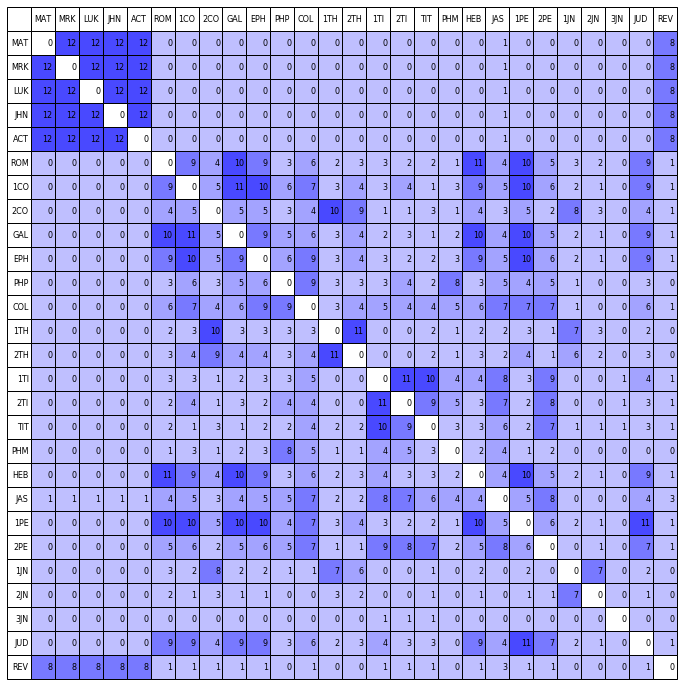

In [164]:
calculate_metric(lang_clusters, book_names)

# metric_table = calculate_metric(lang_clusters, book_names)
# with open(metric_path + 'experiment_1.txt', 'w') as w:
#     w.write("### Exp1 : Without data cleaning ###\n\n" )
#     w.write(str(metric_table))  

In [42]:
''' Find value k for clustering by analyzing the data'''


# Sum_of_squared_distances = []
# K = range(2,10)
# for k in K:
#     km = KMeans(n_clusters=k, max_iter=200, n_init=10)
#     km = km.fit(X)
#     Sum_of_squared_distances.append(km.inertia_)
    
# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()    

## Result 

In [ ]:
# lang ::  mandeali
# cluster :  0 ['3JN']
# cluster :  1 ['2PE', 'JUD']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  3 ['2CO', '1TH', '2TH', '1JN', '2JN']
# cluster :  4 ['PHM']
# cluster :  5 ['ROM', '1CO', 'GAL', 'EPH', 'PHP', 'COL', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE']


# lang ::  haryanvi
# cluster :  0 ['1TI', '2TI', 'TIT', '2PE']
# cluster :  1 ['1JN', '2JN']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  3 ['3JN']
# cluster :  4 ['ROM', '1CO', 'GAL', 'EPH', 'COL', 'PHM', 'HEB', '1PE', 'JUD']
# cluster :  5 ['2CO', 'PHP', '1TH', '2TH', 'JAS']


# lang ::  dogri
# cluster :  0 ['COL', '1TI', '2TI', 'TIT', '1PE', '2PE', '3JN', 'JUD']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
# cluster :  2 ['ROM', '1CO', 'GAL', 'EPH', 'PHP', 'PHM', 'HEB', 'JAS']
# cluster :  3 ['REV']
# cluster :  4 ['2TH', '1JN', '2JN']
# cluster :  5 ['2CO', '1TH']


# lang ::  pahari_mahasui
# cluster :  0 ['1CO', 'EPH', 'PHP', 'COL', '1TI', '2TI', 'TIT', 'PHM', 'JAS', '1PE', '2PE', 'JUD']
# cluster :  1 ['2CO', '1TH', '2TH', '1JN']
# cluster :  2 ['ROM', 'GAL', 'HEB']
# cluster :  3 ['3JN']
# cluster :  4 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  5 ['2JN']


# lang ::  baghlayani
# cluster :  0 ['ROM', '1CO', 'GAL', 'HEB', '1PE', 'JUD']
# cluster :  1 ['EPH', 'PHP', 'COL', '2TI', 'PHM']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  3 ['3JN']
# cluster :  4 ['1TI', 'TIT', 'JAS', '2PE', '2JN']
# cluster :  5 ['2CO', '1TH', '2TH', '1JN']


# lang ::  chambeali
# cluster :  0 ['1CO', 'PHP', 'COL', '1TI', '2TI', 'TIT', 'PHM', 'JAS', '1PE', '2PE', 'JUD']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
# cluster :  2 ['ROM', 'GAL', 'EPH', 'HEB']
# cluster :  3 ['2CO', '1TH', '2TH', '1JN']
# cluster :  4 ['2JN', '3JN']
# cluster :  5 ['REV']


# lang ::  kulvi_outer_seraji
# cluster :  0 ['1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', 'JAS', '1PE', '2PE', 'JUD']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  2 ['1TI', '2TI', 'TIT']
# cluster :  3 ['3JN']
# cluster :  4 ['PHM']
# cluster :  5 ['ROM', 'HEB', '1JN', '2JN']


# lang ::  gaddi
# cluster :  0 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE', '2PE', 'JUD']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  2 ['2JN']
# cluster :  3 ['3JN']
# cluster :  4 ['1JN']
# cluster :  5 ['PHM']


# lang ::  bhadrawahi
# cluster :  0 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', 'HEB', 'JAS', '1PE', '1JN', '2JN']
# cluster :  1 ['PHM', '3JN']
# cluster :  2 ['1TH', '2TH']
# cluster :  3 ['REV']
# cluster :  4 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
# cluster :  5 ['1TI', '2TI', 'TIT', '2PE', 'JUD']


# lang ::  bilaspuri
# cluster :  0 ['3JN']
# cluster :  1 ['2CO', '1TH', '2TH', '1JN']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  3 ['ROM', '1CO', 'GAL', 'EPH', 'PHP', 'COL', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE', '2PE', '2JN']
# cluster :  4 ['JUD']
# cluster :  5 ['PHM']


# lang ::  kulvi
# cluster :  0 ['1TI', '2TI', 'TIT', 'PHM', '2PE']
# cluster :  1 ['ROM', '1CO', 'GAL', 'EPH', 'PHP', 'COL', 'HEB', '1PE']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'JAS', 'REV']
# cluster :  3 ['3JN']
# cluster :  4 ['2CO', '1TH', '2TH', '1JN', '2JN']
# cluster :  5 ['JUD']


# lang ::  kangri
# cluster :  0 ['PHM']
# cluster :  1 ['PHP', '1TI', '2TI', 'TIT', 'JAS', '2PE', '2JN']
# cluster :  2 ['ROM', '1CO', 'GAL', 'EPH', 'COL', '2TH', 'HEB', '1PE', 'JUD']
# cluster :  3 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  4 ['2CO', '1TH', '1JN']
# cluster :  5 ['3JN']
# calculate_metric(lang_clusters, book_names)
# ​

# Experiment 2

- Same procedure in Exp1 is followed with pre-processing - stop word removal.
- Stop words filtered out based on a threshold of word frequency. As first step found threshold value that determines a word is a stop word or not. Plotted graph of word frequencies and found the threshold value by analyzing the graph. Threshold is calculated for each language.
- The filtered out stop word list had words like 'यीशु', 'परमेश्‍वर' etc.. which comes too often. Those words are removed from stop words by checking whether token length is greater than average length of a stop word. 
- Stop-word cleaned data is passed for clustering and metric is calculated as in exp1. 
- The results were improved compared to exp1.

## Finding word frequency threshold 

In [26]:
if 'stop_words' not in os.listdir(cwd):
    os.mkdir('stop_words')  
sw_path = cwd + 'stop_words/'

In [178]:
for lang in os.listdir(minority_path):
#     print("lang :: ", lang)
    words = []
    for book in sorted(os.listdir(minority_path + lang)):
        content = open(minority_path + lang + '/' + book, 'r').read()
        content = clean_text(content)
        words += content.split()
    plot_words(words)
    

In [4]:
freq_thr = {'haryanvi':1350, 'dogri':1200, 'mandeali':1800, 'bilaspuri': 1500, 'kangri': 1600,
            'chambeali':500, 'kulvi':1000, 'baghlayani':1700, 'bhadrawahi':700, 
            'kulvi_outer_seraji': 1000, 'gaddi': 1000, 'pahari_mahasui':800}

## Filtering stop-words 

In [27]:
for lang in os.listdir(minority_path):
#     print("\nlang :: ", lang)
#     print("---------------------------------------------------")
    fp = open(sw_path + lang + '.txt', 'w')
    words = []
    for book in sorted(os.listdir(minority_path + lang)):
        content = open(minority_path + lang + '/' + book, 'r').read()
        content = clean_text(content)
        words += content.split()
    tokens_length = 0  
    temp = []
    for key, value in Counter(words).items():
        if value > freq_thr[lang]:
            tokens_length += len(key)
            temp.append(key)
    avg_len = tokens_length/len(temp)
    filtered_words = []
    for item in temp:
        if len(item)<=round(avg_len):
            filtered_words.append(item)
    fp.write('\n'.join(filtered_words))
    fp.close()

## clustering 

In [165]:
lang_clusters = {}
for lang in min_languages:
    print("\n\nlang :: ", lang)
    books = []
    book_content = []
    book_names = []
    for book in sorted(os.listdir(minority_path + lang)):
        book_names.append(book.split('_')[1][:3])
        stop_words = open(sw_path + lang + '.txt').readlines()
        stop_words = [item.strip() for item in stop_words]
        books.append(book.split('.')[0])
        content = open(minority_path + lang + '/' + book, 'r').read()
        content = clean_text(content) 
        words = [item for item in content.split() if item not in stop_words]
        content = ' '.join(words)
        book_content.append(content)
    df_clusters = cluster_books(books, book_content)
    lang_clusters[lang] = arrange_clusters(df_clusters)
    



lang ::  mandeali
cluster :  0 ['PHM']
cluster :  1 ['ROM', 'GAL', 'HEB']
cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
cluster :  3 ['1CO', 'EPH', 'PHP', 'COL', '1TI', '2TI', 'JAS', '1PE', '2PE', 'JUD', 'REV']
cluster :  4 ['3JN']
cluster :  5 ['2CO', '1TH', '2TH', 'TIT', '1JN', '2JN']


lang ::  haryanvi
cluster :  0 ['ROM', '1CO', 'GAL', 'EPH', 'PHP', 'COL', '2TH', '1TI', '2TI', 'TIT', 'PHM', 'HEB', 'JAS', '1PE', '2PE', 'JUD']
cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
cluster :  2 ['2CO', '1TH', '1JN']
cluster :  3 ['REV']
cluster :  4 ['2JN']
cluster :  5 ['3JN']


lang ::  dogri
cluster :  0 ['1CO', '2CO', 'EPH', 'PHP', 'COL', '1TH', '2TH', 'PHM', 'JAS']
cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
cluster :  2 ['3JN']
cluster :  3 ['1TI', '2TI', 'TIT', '1PE', '2PE', 'JUD']
cluster :  4 ['REV']
cluster :  5 ['ROM', 'GAL', 'HEB', '1JN', '2JN']


lang ::  pahari_mahasui
cluster :  0 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
cluster :  1 ['PHP', '2TI']
cluster :  2 [

## Metric 

color_groups : 
 {'0-3.0': '#BFBFFF', '3.0-6.0': '#A3A3FF', '6.0-9.0': '#7879FF', '9.0-12.0': '#4949FF'}


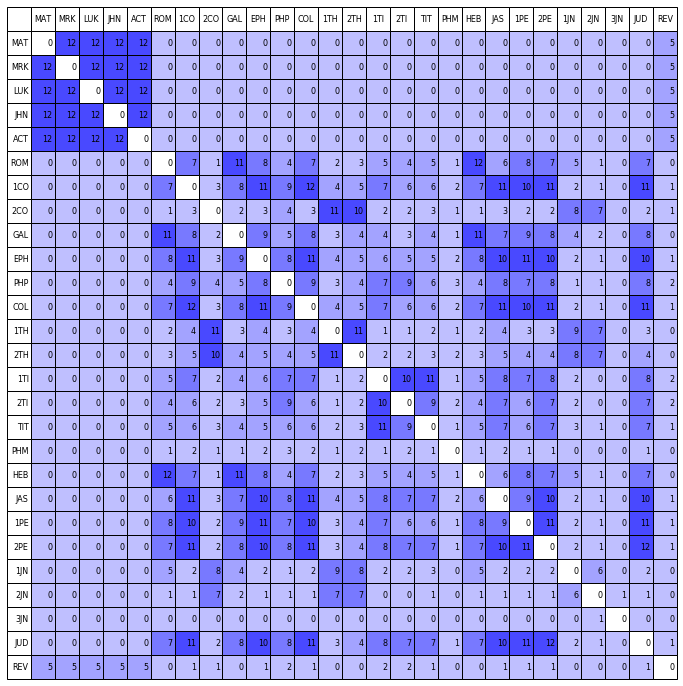

In [166]:
calculate_metric(lang_clusters, book_names)

# metric_table = calculate_metric(lang_clusters, book_names)
# with open(metric_path + 'experiment_2.txt', 'w') as w:
#     w.write("### Exp2 : Without stop words ###\n\n" )
#     w.write(str(metric_table))  

## Result 

In [9]:
# lang ::  mandeali
# cluster :  0 ['3JN']
# cluster :  1 ['ROM', '1CO', 'GAL', 'EPH', 'PHP', 'COL', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE', '2PE', '2JN', 'JUD']
# cluster :  2 ['REV']
# cluster :  3 ['PHM']
# cluster :  4 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
# cluster :  5 ['2CO', '1TH', '2TH', '1JN']


# lang ::  haryanvi
# cluster :  0 ['REV']
# cluster :  1 ['PHP', 'PHM']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
# cluster :  3 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'COL', '1TH', '2TH', 'HEB', 'JAS', '1PE', '2PE', '1JN', 'JUD']
# cluster :  4 ['1TI', '2TI', 'TIT', '3JN']
# cluster :  5 ['2JN']


# lang ::  dogri
# cluster :  0 ['1TI', '2TI', 'TIT', '2PE', 'JUD']
# cluster :  1 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', 'PHM', 'HEB', 'JAS']
# cluster :  2 ['REV']
# cluster :  3 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
# cluster :  4 ['1TH', '2TH', '1PE', '1JN', '2JN']
# cluster :  5 ['3JN']


# lang ::  pahari_mahasui
# cluster :  0 ['2CO', '1TH', '2TH', '1JN', '2JN']
# cluster :  1 ['ROM', '1CO', 'GAL', 'EPH', 'PHP', 'COL', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE', 'JUD']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  3 ['3JN']
# cluster :  4 ['2PE']
# cluster :  5 ['PHM']


# lang ::  baghlayani
# cluster :  0 ['GAL', 'HEB']
# cluster :  1 ['PHP', '2TI', 'PHM']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  3 ['ROM', '1CO', 'EPH', 'COL', '1TI', 'TIT', 'JAS', '1PE', '2PE', 'JUD']
# cluster :  4 ['2CO', '1TH', '2TH', '1JN', '2JN']
# cluster :  5 ['3JN']


# lang ::  chambeali
# cluster :  0 ['PHP', 'COL', '2TH']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
# cluster :  2 ['PHM']
# cluster :  3 ['3JN']
# cluster :  4 ['REV']
# cluster :  5 ['ROM', '1CO', '2CO', 'GAL', 'EPH', '1TH', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE', '2PE', '1JN', '2JN', 'JUD']


# lang ::  kulvi_outer_seraji
# cluster :  0 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  1 ['ROM', '1TI', '2TI', 'TIT', 'HEB', '1JN']
# cluster :  2 ['1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', 'JAS', '1PE', '2PE', 'JUD']
# cluster :  3 ['3JN']
# cluster :  4 ['2JN']
# cluster :  5 ['PHM']


# lang ::  gaddi
# cluster :  0 ['JUD']
# cluster :  1 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE', '2PE', '1JN']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  3 ['3JN']
# cluster :  4 ['PHM']
# cluster :  5 ['2JN']


# lang ::  bhadrawahi
# cluster :  0 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', 'HEB', 'JAS', '1PE', '1JN', '2JN']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT']
# cluster :  2 ['3JN']
# cluster :  3 ['PHM']
# cluster :  4 ['REV']
# cluster :  5 ['1TI', '2TI', 'TIT', '2PE', 'JUD']


# lang ::  bilaspuri
# cluster :  0 ['PHM']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  2 ['PHP', '1TI', '2TI', 'TIT', '2PE', 'JUD']
# cluster :  3 ['ROM', '1CO', 'GAL', 'EPH', 'COL', '2TH', 'HEB', 'JAS', '1PE']
# cluster :  4 ['3JN']
# cluster :  5 ['2CO', '1TH', '1JN', '2JN']


# lang ::  kulvi
# cluster :  0 ['ROM', '1CO', 'GAL', 'EPH', 'PHP', 'COL', '2TH', '2TI', 'HEB', '1PE', 'JUD']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'JAS', 'REV']
# cluster :  2 ['3JN']
# cluster :  3 ['PHM']
# cluster :  4 ['2CO', '1TH', '1JN', '2JN']
# cluster :  5 ['1TI', 'TIT', '2PE']


# lang ::  kangri
# cluster :  0 ['ROM', '1CO', 'GAL', 'EPH', 'PHP', 'COL', 'HEB', '1PE', '2PE', 'JUD']
# cluster :  1 ['2CO', '1TH', '2TH', 'PHM', '1JN']
# cluster :  2 ['3JN']
# cluster :  3 ['1TI', '2TI', 'TIT', 'JAS']
# cluster :  4 ['2JN']
# cluster :  5 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']

# Experiment 3

- Experiment3 is conducted by considering unique words only also stop words were removed.
- Followed same procedure with k-means.
- The metric shows a good result compared to previous 2 experiments.

In [45]:
min_lang_clusters = {}
for lang in min_languages:
    print("\n\nlang :: ", lang)
    books = []
    book_content = []
    book_names = []
    for book in sorted(os.listdir(minority_path + lang)):
        book_names.append(book.split('_')[1][:3])
        stop_words = open(sw_path + lang + '.txt').readlines()
        stop_words = [item.strip() for item in stop_words]
        books.append(book.split('.')[0])
        content = open(minority_path + lang + '/' + book, 'r').read()
        content = clean_text(content) 
        words = [item for item in list(set(content.split())) if item not in stop_words]
        content = ' '.join(words)
        book_content.append(content)
    df_clusters = cluster_books(books, book_content)
    min_lang_clusters[lang] = arrange_clusters(df_clusters)



lang ::  mandeali
cluster :  0 ['3JN']
cluster :  1 ['2TH', '1TI', 'TIT', 'JAS', '1JN']
cluster :  2 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TI', 'HEB', '1PE', '2PE', 'JUD']
cluster :  3 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
cluster :  4 ['PHM']
cluster :  5 ['2JN']


lang ::  haryanvi
cluster :  0 ['JAS']
cluster :  1 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', '1TI', '2TI', 'TIT', 'HEB', '1PE', '1JN']
cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
cluster :  3 ['PHM', '2JN', '3JN']
cluster :  4 ['JUD']
cluster :  5 ['2PE']


lang ::  dogri
cluster :  0 ['HEB', '1PE']
cluster :  1 ['EPH', 'COL', '2TH']
cluster :  2 ['ROM', '1CO', '2CO', 'GAL', 'PHP', '1TH', '1TI', '2TI', 'TIT', 'PHM', 'JAS', '1JN']
cluster :  3 ['2JN', '3JN']
cluster :  4 ['2PE', 'JUD']
cluster :  5 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']


lang ::  pahari_mahasui
cluster :  0 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
cluster :  1 ['EPH', 'COL', '1TH', '2TH', 

## Metric 

color_groups : 
 {'0-3.0': '#BFBFFF', '3.0-6.0': '#A3A3FF', '6.0-9.0': '#7879FF', '9.0-12.0': '#4949FF'}


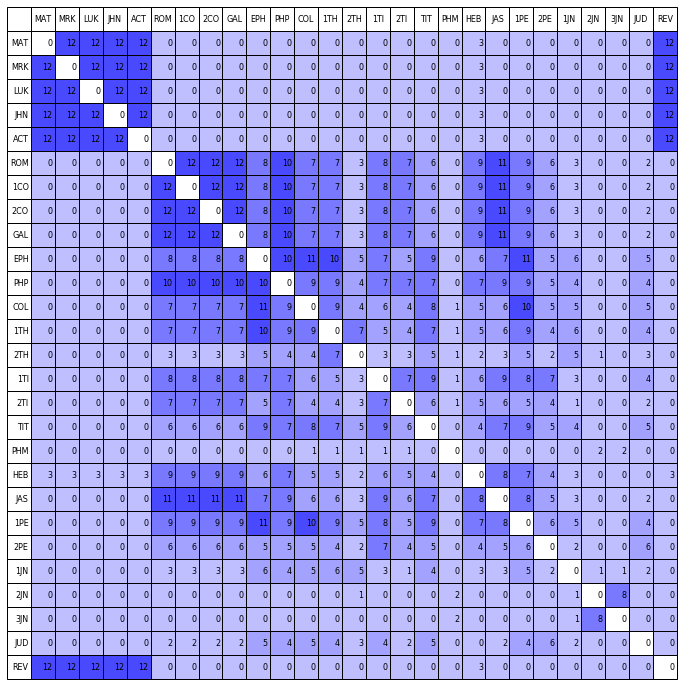

In [11]:
calculate_metric(min_lang_clusters, book_names)


## Result 

In [ ]:
# lang ::  mandeali
# cluster :  0 ['PHP', 'COL', '1TH', '2TH']
# cluster :  1 ['EPH', 'TIT', '1PE', '1JN', 'JUD']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  3 ['2JN', '3JN']
# cluster :  4 ['PHM']
# cluster :  5 ['ROM', '1CO', '2CO', 'GAL', '1TI', '2TI', 'HEB', 'JAS', '2PE']


# lang ::  haryanvi
# cluster :  0 ['2TH']
# cluster :  1 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE', '1JN']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  3 ['JUD']
# cluster :  4 ['2PE']
# cluster :  5 ['PHM', '2JN', '3JN']


# lang ::  dogri
# cluster :  0 ['1TI', '2TI', 'TIT', 'PHM', 'JUD']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  2 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', 'HEB', 'JAS', '1PE']
# cluster :  3 ['2PE']
# cluster :  4 ['2JN', '3JN']
# cluster :  5 ['2TH', '1JN']


# lang ::  pahari_mahasui
# cluster :  0 ['2JN']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  2 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE', '2PE']
# cluster :  3 ['1TH', '2TH', '1JN', 'JUD']
# cluster :  4 ['PHM']
# cluster :  5 ['3JN']


# lang ::  baghlayani
# cluster :  0 ['EPH', 'COL', '2TH', '1PE', 'JUD']
# cluster :  1 ['2JN', '3JN']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'HEB', 'REV']
# cluster :  3 ['1TI', '2TI', 'TIT']
# cluster :  4 ['ROM', '1CO', '2CO', 'GAL', 'PHP', '1TH', 'JAS', '2PE', '1JN']
# cluster :  5 ['PHM']


# lang ::  chambeali
# cluster :  0 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  1 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE', '1JN']
# cluster :  2 ['2TH']
# cluster :  3 ['2JN', '3JN']
# cluster :  4 ['2PE', 'JUD']
# cluster :  5 ['PHM']


# lang ::  kulvi_outer_seraji
# cluster :  0 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  1 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'COL', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE']
# cluster :  2 ['PHM', '2JN']
# cluster :  3 ['2PE', 'JUD']
# cluster :  4 ['PHP', '1TH', '2TH', '1JN']
# cluster :  5 ['3JN']


# lang ::  gaddi
# cluster :  0 ['TIT']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  2 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'COL', '1TI', '2TI', 'HEB', 'JAS', '1PE', '2PE', '1JN', 'JUD']
# cluster :  3 ['PHP', '1TH', '2TH']
# cluster :  4 ['2JN', '3JN']
# cluster :  5 ['PHM']


# lang ::  bhadrawahi
# cluster :  0 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  1 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TI', 'HEB', '1PE', '2PE', 'JUD']
# cluster :  2 ['2JN', '3JN']
# cluster :  3 ['1TH', '2TH', 'JAS', '1JN']
# cluster :  4 ['2TI', 'TIT']
# cluster :  5 ['PHM']


# lang ::  bilaspuri
# cluster :  0 ['3JN']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'HEB', 'REV']
# cluster :  2 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', '1TI', '2TI', 'TIT', 'JAS', '1PE', '1JN']
# cluster :  3 ['2JN']
# cluster :  4 ['2PE', 'JUD']
# cluster :  5 ['PHM']


# lang ::  kulvi
# cluster :  0 ['1JN']
# cluster :  1 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE', '2PE', 'JUD']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  3 ['PHM']
# cluster :  4 ['2JN', '3JN']
# cluster :  5 ['1TH', '2TH']


# lang ::  kangri
# cluster :  0 ['1TH', '2TH', 'PHM', '1JN']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'HEB', 'REV']
# cluster :  2 ['2JN', '3JN']
# cluster :  3 ['1TI', 'TIT']
# cluster :  4 ['2PE', 'JUD']
# cluster :  5 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '2TI', 'JAS', '1PE']

# Experiment 4

- With minority languages good results are seeing for exp3. And in exp4 following the steps in exp3 for gateway languages.
- Input data is 27 NT books of 13 gateway languages including english. Files are in usfm format and are parsed using usfm-grammar
- For further procedures 'urdu', 'odiya', 'english' are not using as parsing was not successful for files in these languages. So experimenting with 10 languages only.
- For filtering stop words plotted graph of word_frequency and found threshold for each language. Filtered out words having frequncy greater than threshold and considering as stop words.
- Then clustered books and plotted metric by considering cluster output of all 10 languages.
- Metric shows that almost same grouping found for gl as minorities.

In [24]:
''' Parsing usfm files '''

for gl in os.listdir(gl_path):
#     print(gl)
    if not gl=='english':
        continue
    for book in os.listdir(gl_path + gl):
        os.system("usfm-grammar "+gl_path+gl+'/'+book+" -o csv >> "+gl_path+gl+'/'+book+".csv")  

In [4]:
for lang in gl_languages:
    if lang in ['urdu', 'odiya', 'english']:
        continue   
    print(lang)
    for book in os.listdir(gl_path + lang):
        if book.endswith('csv'):
            name = book.split('.')[0]
            fp = open(gl_path + lang+'/'+name + '.txt', 'w')
            df = pd.read_csv(gl_path + lang+'/'+book)
            df = df.dropna()
            fp.write('\n'.join(list(df[' Text'])))
            fp.close() 

punjabi
malayalam
telegu
kannada
bengali
marathi
tamil
gujarati
hindi
assamese


lang ::  punjabi


/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2565 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2596 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2631 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2598 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2600 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211:

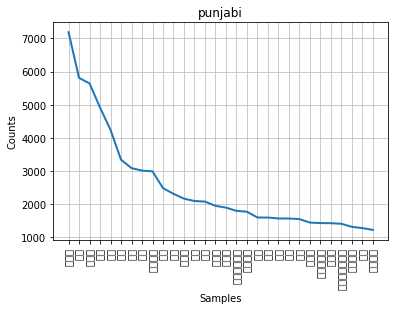

lang ::  malayalam


/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3342 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3393 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3358 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211:

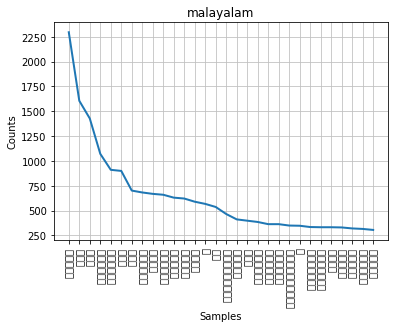

lang ::  telegu


/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3078 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3119 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3112 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3077 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3135 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211:

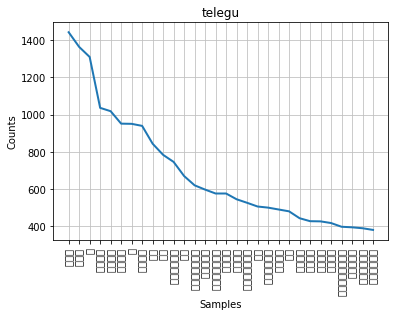

lang ::  kannada


/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3214 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3202 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3238 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3265 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3206 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211:

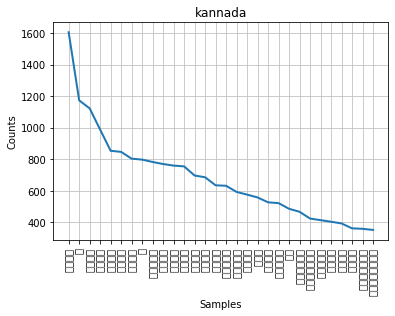

lang ::  odiya


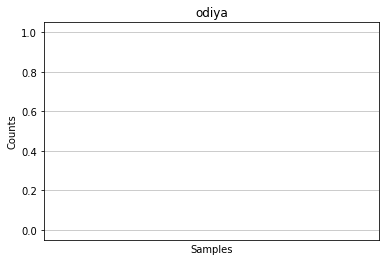

lang ::  bengali


/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2447 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2476 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2434 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2472 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211:

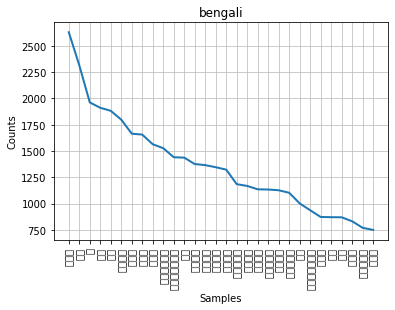

lang ::  marathi


/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2310 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2339 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2367 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2375 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211:

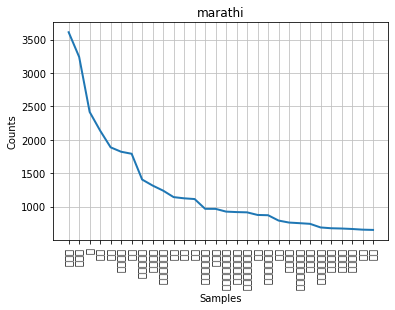

lang ::  tamil


/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2958 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2985 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3021 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2993 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3009 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211:

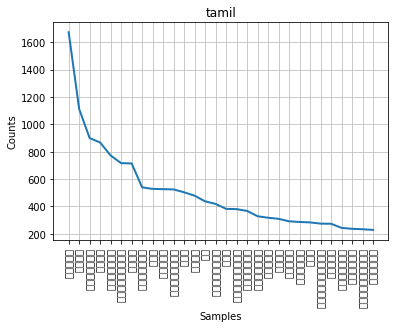

lang ::  gujarati


/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2715 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2759 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2709 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2693 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211:

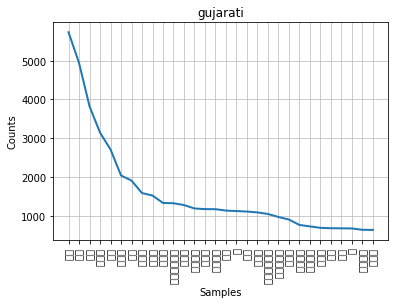

lang ::  hindi


/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2375 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211:

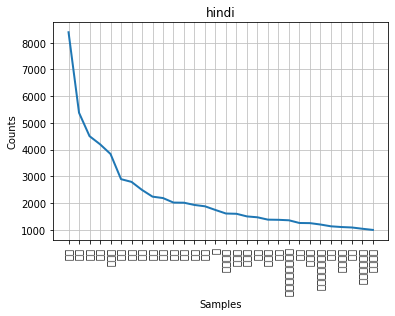

lang ::  assamese


/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2438 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2544 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2497 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2488 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2503 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/anjaly/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211:

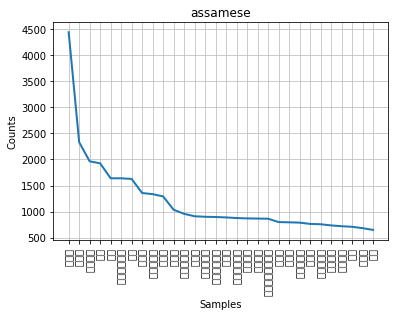

lang ::  urdu


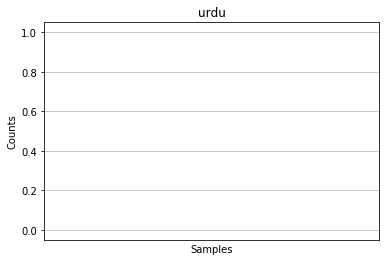

In [45]:
for lang in os.listdir(gl_path):
    print("lang :: ", lang)
    words = []
    for book in sorted(os.listdir(gl_path + lang)):
        if not book.endswith('txt'):
            continue
#         print(book)
        content = open(gl_path + lang + '/' + book, 'r').read()
        content = clean_text(content)
        words += content.split()
    
    fdist = FreqDist(words)
    fdist.plot(30,title=lang)

In [24]:
freq_thr = {'punjabi':1500, 'malayalam':200, 'telegu':400, 'kannada': 300, 'odiya':1100 ,
            'bengali':700, 'marathi':500, 'tamil':300, 'gujarati':800, 
            'hindi':1200 , 'assamese':600 , 'urdu':1000}

In [26]:
for lang in os.listdir(gl_path):
#     print("\nlang :: ", lang)
#     print("---------------------------------------------------")
    if lang in ['urdu', 'odiya', 'english']:
        continue
    fp = open(sw_path + lang + '.txt', 'w')
    words = []
    for book in sorted(os.listdir(gl_path + lang)):
        if not book.endswith('txt'):
            continue    
        content = open(gl_path + lang + '/' + book, 'r').read()
        content = clean_text(content)
        words += content.split()
    tokens_length = 0  
    temp = []
    for key, value in Counter(words).items():
        if value > freq_thr[lang]:
            tokens_length += len(key)
            temp.append(key)        
    avg_len = tokens_length/len(temp)
    filtered_words = []
    for item in temp:
        if len(item)<=round(avg_len):
            filtered_words.append(item)
#     print(len(filtered_words))        
    fp.write('\n'.join(filtered_words))
    fp.close()

## Clustering 

In [12]:
gl_lang_clusters = {}
for lang in gl_languages:
    print("\n\nlang :: ", lang)
    if lang in ['urdu', 'odiya','english']:
        continue
    books = []
    book_content = []
    book_names = []
    for book in sorted(os.listdir(gl_path+lang)):
        if not book.endswith('txt'):
            continue 
        book_names.append(book.split('_')[1][:3])
        stop_words = open(sw_path + lang + '.txt').readlines()
        stop_words = [item.strip() for item in stop_words]
        books.append(book.split('.')[0])
        content = open(gl_path + lang + '/' + book, 'r').read()
        content = clean_text(content) 
        words = [item for item in list(set(content.split())) if item not in stop_words]
        content = ' '.join(words)
        book_content.append(content)
    df_clusters = cluster_books(books, book_content)
    gl_lang_clusters[lang] = arrange_clusters(df_clusters)



lang ::  english


lang ::  punjabi
cluster :  0 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
cluster :  1 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE']
cluster :  2 ['2JN', '3JN']
cluster :  3 ['PHM']
cluster :  4 ['2PE', 'JUD']
cluster :  5 ['1TH', '2TH', '1JN']


lang ::  malayalam
cluster :  0 ['EPH', 'PHP', 'COL', '2TH', '1PE']
cluster :  1 ['2JN']
cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'ROM', '1CO', '2CO', 'GAL', '1TH', '1TI', '2TI', 'HEB', 'JAS', '2PE', '1JN', 'JUD', 'REV']
cluster :  3 ['PHM']
cluster :  4 ['3JN']
cluster :  5 ['TIT']


lang ::  telegu
cluster :  0 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE', '1JN', 'REV']
cluster :  1 ['3JN']
cluster :  2 ['2JN']
cluster :  3 ['PHM']
cluster :  4 ['JUD']
cluster :  5 ['2PE']


lang ::  kannada
cluster :  0 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '1TI', '2TI', '

## Metric 

color_groups : 
 {'0-2.5': '#BFBFFF', '2.5-5.0': '#A3A3FF', '5.0-7.5': '#7879FF', '7.5-10.0': '#4949FF'}


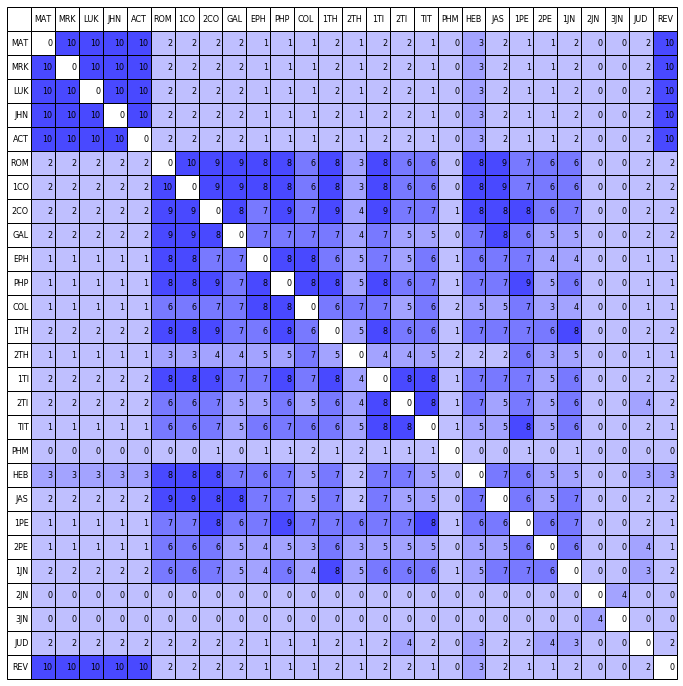

In [13]:
calculate_metric(gl_lang_clusters, book_names)



## Result 

In [50]:
# lang ::  tamil
# cluster :  0 ['ROM', '1CO', '2CO', 'GAL', '2TH', '2TI', 'JAS']
# cluster :  1 ['PHM']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'EPH', 'COL', '1TH', '1TI', 'TIT', 'HEB', '1PE', '2PE', 'JUD', 'REV']
# cluster :  3 ['2JN']
# cluster :  4 ['3JN']
# cluster :  5 ['PHP', '1JN']


# lang ::  urdu


# lang ::  odiya


# lang ::  punjabi
# cluster :  0 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', '1TI', '2TI', 'TIT', 'JAS', '1PE', '2PE', '1JN']
# cluster :  1 ['2JN']
# cluster :  2 ['PHM']
# cluster :  3 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'HEB', 'REV']
# cluster :  4 ['JUD']
# cluster :  5 ['3JN']


# lang ::  hindi
# cluster :  0 ['JUD']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'HEB', 'REV']
# cluster :  2 ['2JN', '3JN']
# cluster :  3 ['PHM']
# cluster :  4 ['2CO', 'PHP', '1TH', '2TH', 'JAS', '1PE', '1JN']
# cluster :  5 ['ROM', '1CO', 'GAL', 'EPH', 'COL', '1TI', '2TI', 'TIT', '2PE']


# lang ::  gujarati
# cluster :  0 ['JAS']
# cluster :  1 ['2JN', '3JN']
# cluster :  2 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', '1TI', 'TIT', 'HEB', '1PE', '2PE', '1JN', 'JUD']
# cluster :  3 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  4 ['PHM']
# cluster :  5 ['2TI']


# lang ::  malayalam
# cluster :  0 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'GAL', '1TI', '2TI', 'JAS', 'REV']
# cluster :  1 ['ROM', '1CO', '2CO', 'EPH', 'PHP', 'COL', '1TH', '2TH', 'TIT', 'HEB', '1PE', '2PE']
# cluster :  2 ['3JN']
# cluster :  3 ['PHM']
# cluster :  4 ['JUD']
# cluster :  5 ['1JN', '2JN']


# lang ::  marathi
# cluster :  0 ['2PE']
# cluster :  1 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'HEB', 'JUD', 'REV']
# cluster :  2 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', '1TI', '2TI', 'TIT', 'JAS', '1PE', '1JN']
# cluster :  3 ['2JN']
# cluster :  4 ['PHM']
# cluster :  5 ['3JN']


# lang ::  telegu
# cluster :  0 ['2TH']
# cluster :  1 ['EPH', 'COL', '1TH', '1TI', '2TI', 'TIT', '1PE', 'JUD']
# cluster :  2 ['2JN']
# cluster :  3 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'ROM', '1CO', '2CO', 'GAL', 'PHP', 'HEB', 'JAS', '2PE', '1JN', 'REV']
# cluster :  4 ['PHM']
# cluster :  5 ['3JN']


# lang ::  kannada
# cluster :  0 ['2TI', 'TIT']
# cluster :  1 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', '1TI', 'HEB', 'JAS', '1PE', '2PE', '1JN', 'JUD']
# cluster :  2 ['PHM']
# cluster :  3 ['3JN']
# cluster :  4 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  5 ['2JN']


# lang ::  assamese
# cluster :  0 ['1JN', '2JN', '3JN']
# cluster :  1 ['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '2TH', '1TI', '2TI', 'HEB', 'JAS', '1PE', '2PE']
# cluster :  2 ['JUD']
# cluster :  3 ['TIT']
# cluster :  4 ['PHM']
# cluster :  5 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']


# lang ::  bengali
# cluster :  0 ['EPH', 'COL', '2TH', '2TI', 'TIT', 'JAS', '1PE', '1JN', 'JUD']
# cluster :  1 ['3JN']
# cluster :  2 ['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV']
# cluster :  3 ['PHM']
# cluster :  4 ['2JN']
# cluster :  5 ['ROM', '1CO', '2CO', 'GAL', 'PHP', '1TH', '1TI', 'HEB', '2PE']

# Analyzing common groupings

- Experiment with unique words and without stop words gives the good result (exp3 for min languages and exp4 for gl).
- Trying to identify common groupings by analyzing the results of exp3 and exp4
- Clubbed all clusters of minorities and gl. Found frequency of all individual clusters. While counting partial match also considered ie, cluster (a,b) is there in cluster (a,b,c,d). 
- Sorted the clusters based on frequency and found common groupings among 22 languages.
- Group ('MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV') is the most common pattern which occurred 22 times.
- PHM alone formed a cluster having 14 occurrences. For clusters having single element like (PHM) partial match not counted

In [14]:
len(min_lang_clusters)

12

In [15]:
len(gl_lang_clusters)

10

In [25]:
groups = []
for lang, cluster in min_lang_clusters.items():
#     print("lang : ", lang)
    for key, value in cluster.items():
        groups.append(tuple(value))
for lang, cluster in gl_lang_clusters.items():
#     print("lang : ", lang)
    for key, value in cluster.items():
        groups.append(tuple(value))
        
common_groups = sorted(Counter(groups).items(), key=lambda i: len(i[0])) 
common_groups = [[list(item[0]), item[1]]for item in common_groups]
for item in common_groups:
    print(list(item))

[['1JN'], 3]
[['PHM'], 14]
[['2TH'], 2]
[['3JN'], 9]
[['JUD'], 7]
[['2PE'], 4]
[['2TI'], 1]
[['2JN'], 8]
[['TIT'], 1]
[['2JN', '3JN'], 10]
[['2TH', '2TI'], 1]
[['2TH', 'JUD'], 1]
[['PHM', '2JN'], 1]
[['2TH', '1JN'], 1]
[['2PE', 'JUD'], 3]
[['2TI', 'TIT'], 1]
[['PHM', '3JN'], 1]
[['2TH', '2JN'], 1]
[['COL', 'PHM'], 1]
[['JAS', '1JN'], 1]
[['PHM', '2JN', '3JN'], 1]
[['1TI', 'TIT', 'JAS'], 1]
[['1JN', '2JN', '3JN'], 1]
[['1TI', '2TI', 'PHM'], 1]
[['1TH', '2TH', '1JN'], 2]
[['1TH', '2TH', 'PHM'], 1]
[['2TI', 'HEB', 'JUD'], 1]
[['GAL', 'COL', '2TH'], 1]
[['1TI', '2TI', 'TIT'], 1]
[['EPH', 'COL', '2TH', 'PHM'], 1]
[['1TI', '2TI', 'TIT', '2PE', 'JUD'], 1]
[['EPH', 'PHP', 'COL', '2TH', '1PE'], 1]
[['ROM', '1CO', 'GAL', 'EPH', 'JAS'], 1]
[['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV'], 15]
[['ROM', '1CO', '2CO', 'GAL', 'HEB', 'JAS'], 1]
[['EPH', 'PHP', 'COL', '1TH', '1JN', 'JUD'], 1]
[['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'HEB', 'REV'], 4]
[['EPH', 'COL', '1TH', '2TH', 'TIT', '1PE', '1JN'], 1]
[['ROM

In [26]:
out = []
for i,entry in enumerate(common_groups):
    if len(entry[0]) == 1:
        out.append(entry) 
        continue    
    count = entry[1]
    for j,item in enumerate(common_groups):
        if entry == item:
            continue
        if(set(entry[0]).issubset(set(item[0]))):
            count += item[1]
    out.append([entry[0], count])        

In [27]:
common_groups = sorted(out, key=lambda i: i[1], reverse=True)
for item in common_groups:
    print(item[0],"\t:", item[1])

['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'REV'] 	: 22
['PHM'] 	: 14
['2TI', 'TIT'] 	: 14
['ROM', '1CO', '2CO', 'GAL', 'HEB', 'JAS'] 	: 14
['ROM', '1CO', 'GAL', 'EPH', 'JAS'] 	: 13
['2JN', '3JN'] 	: 12
['1TI', 'TIT', 'JAS'] 	: 12
['1TI', '2TI', 'TIT'] 	: 12
['2TH', '1JN'] 	: 10
['2PE', 'JUD'] 	: 10
['JAS', '1JN'] 	: 10
['3JN'] 	: 9
['ROM', '1CO', '2CO', 'GAL', 'PHP', '2TI', 'JAS'] 	: 9
['2JN'] 	: 8
['1TH', '2TH', '1JN'] 	: 8
['JUD'] 	: 7
['2TH', '2TI'] 	: 7
['EPH', 'PHP', 'COL', '2TH', '1PE'] 	: 7
['GAL', 'COL', '2TH'] 	: 6
['MAT', 'MRK', 'LUK', 'JHN', 'ACT', 'HEB', 'REV'] 	: 6
['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', '1TI', 'HEB', 'JAS'] 	: 5
['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TI', '2TI', 'TIT', 'HEB', 'JAS', '1PE'] 	: 5
['2PE'] 	: 4
['2TH', 'JUD'] 	: 4
['EPH', 'COL', '1TH', '2TH', 'TIT', '1PE', '1JN'] 	: 4
['ROM', '1CO', '2CO', 'GAL', 'EPH', 'PHP', 'COL', '1TH', 'HEB', 'JAS', '1PE', '1JN'] 	: 4
['1JN'] 	: 3
['COL', 'PHM'] 	: 3
['2TI', 'HEB', 'JUD'] 	: 3
['1

# Metric on unique words 

- Calculating a metric for unique words shared across 27 NT books
- This is calculated for each language. Metric is plotted as a (27 X 27) table.
- Each cell value says percentage of common unique words shared by x_book and y_book. ie, 
  (number of common words / total words in x_book)
- Cell values are percentage values and colors are given using gradient color scheme.
- Data used is 27 NT books of 12 minority languages
- Pre-processing is done - stop word removal
- 'plot_single_words' module returns the metric table data

In [8]:
def plot_single_words(lang, path):
    print("\n\nPloting single word counts :", lang)
#     for lang in languages:
    book_names = []
    book_words = {}
    for book in sorted(os.listdir(path+lang)):
        if not book.endswith('txt'):
            continue
        name = book.split('_')[1][:3]
        book_names.append(name)
        stop_words = open(sw_path + lang + '.txt').readlines()
        stop_words = [item.strip() for item in stop_words]
        content = open(path + lang + '/' + book, 'r').read()
        content = clean_text(content) 
        words = [item for item in list(set(content.split())) if item not in stop_words]
        book_words[name] = words
    rows = calculate_metric_words(lang, book_names, book_words) 
    return rows

 - Same as plotting single words, metric for unique 3-grams also plotted
 - Stop words are not removed in this case, as stop words plays significant role in forming n-grams
 - Result was not much good

In [9]:
def plot_3_grams(lang, path):
    print("\n\nPloting 3-gram counts :", lang)
#     for lang in languages:
#     print("\n\n language: ", lang)
    book_names = []
    book_words = {}
    for book in sorted(os.listdir(path+lang)):
        if not book.endswith('txt'):
            continue
        name = book.split('_')[1][:3]
        book_names.append(name)
        content = open(path + lang + '/' + book, 'r').read()
        content = clean_text(content) 
        three_grams = ngrams(content.split(), 3)
        book_words[name] = list(set(list(three_grams)))
    rows = calculate_metric_words(book_names, book_words)  

In [54]:
if 'metric_words' not in os.listdir(metric_path):
    os.mkdir(metric_path + 'metric_words')
if 'single_words' not in os.listdir(metric_path+'metric_words'):
    os.mkdir(metric_path + 'metric_words/single_words')

## Minority languages 

- Calculating  metric for unique words across 27 NT books in 12 minority languages

mandeali


Ploting single word counts : mandeali
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


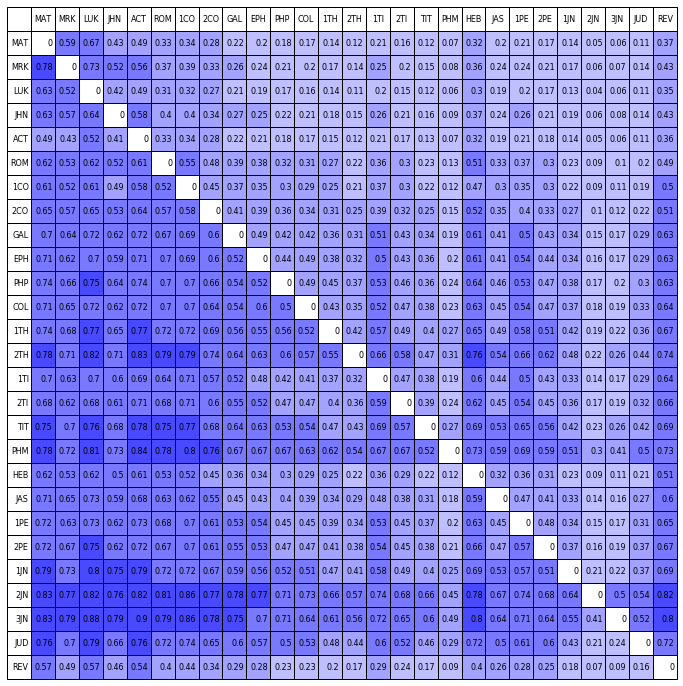

haryanvi


Ploting single word counts : haryanvi
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

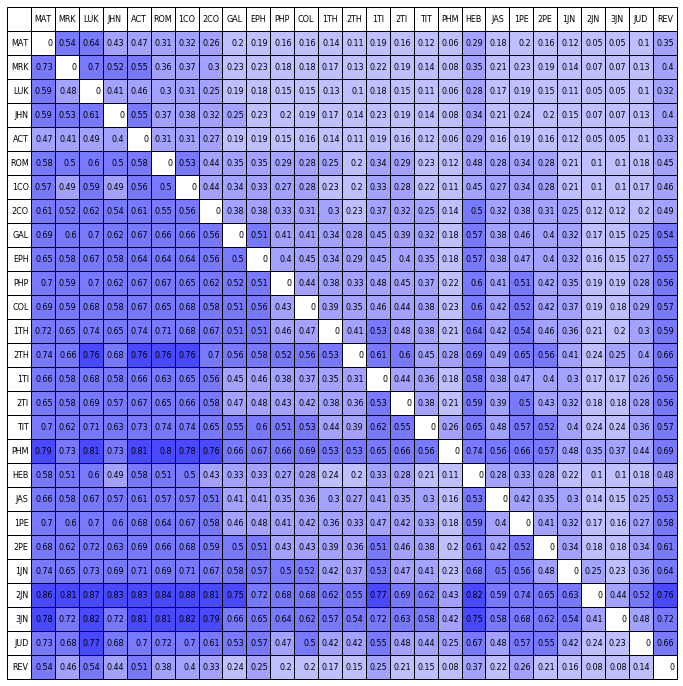

dogri


Ploting single word counts : dogri
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

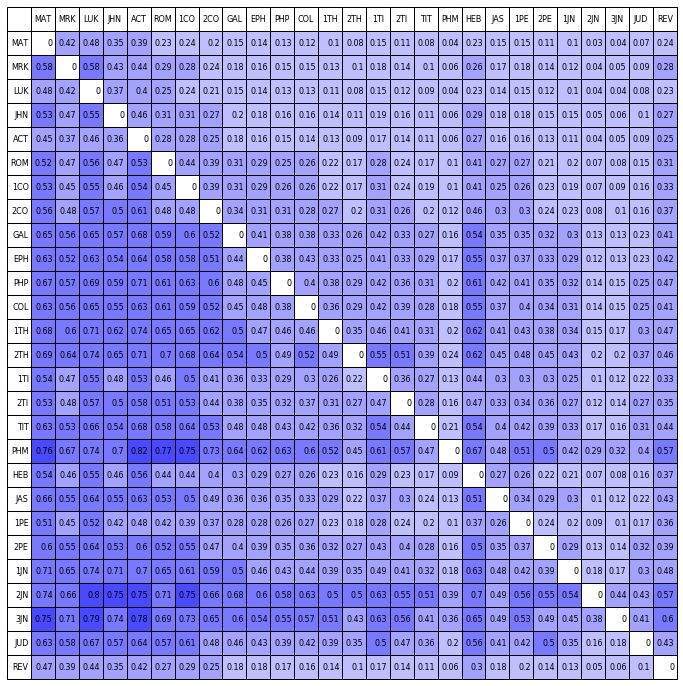

pahari_mahasui


Ploting single word counts : pahari_mahasui
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

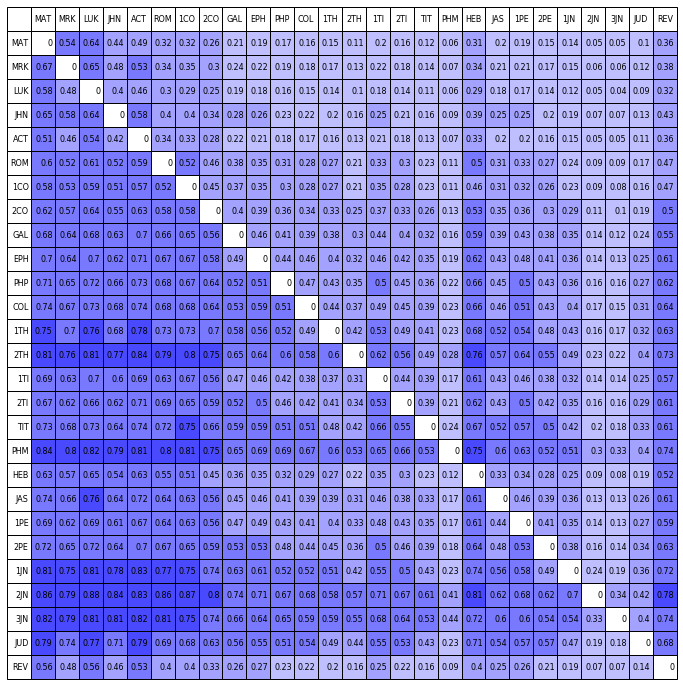

baghlayani


Ploting single word counts : baghlayani
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

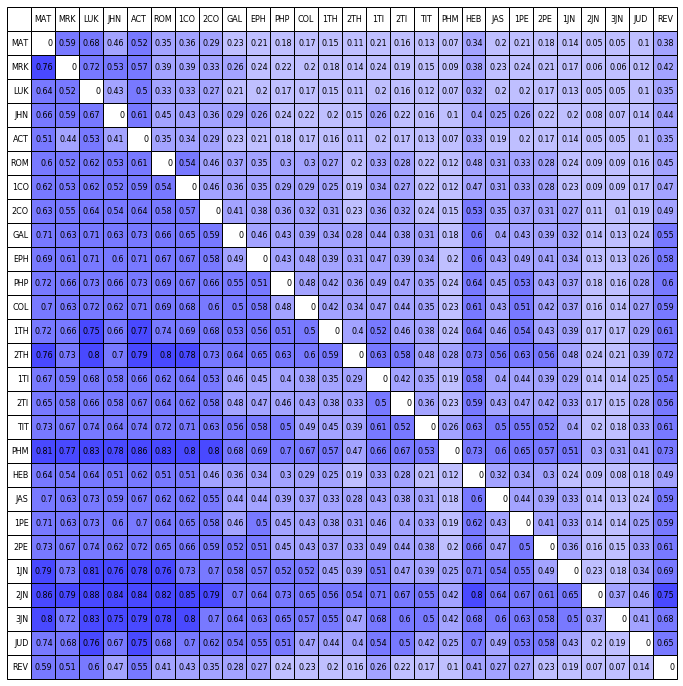

chambeali


Ploting single word counts : chambeali
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

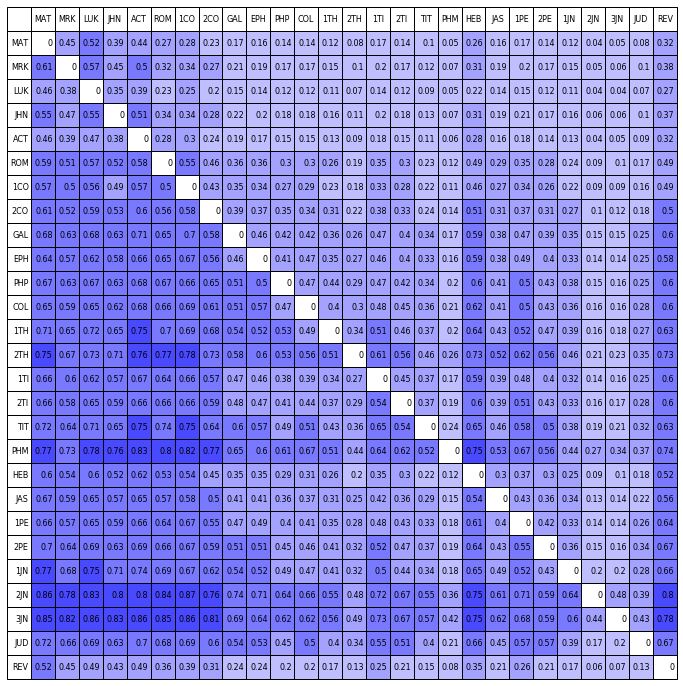

kulvi_outer_seraji


Ploting single word counts : kulvi_outer_seraji
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

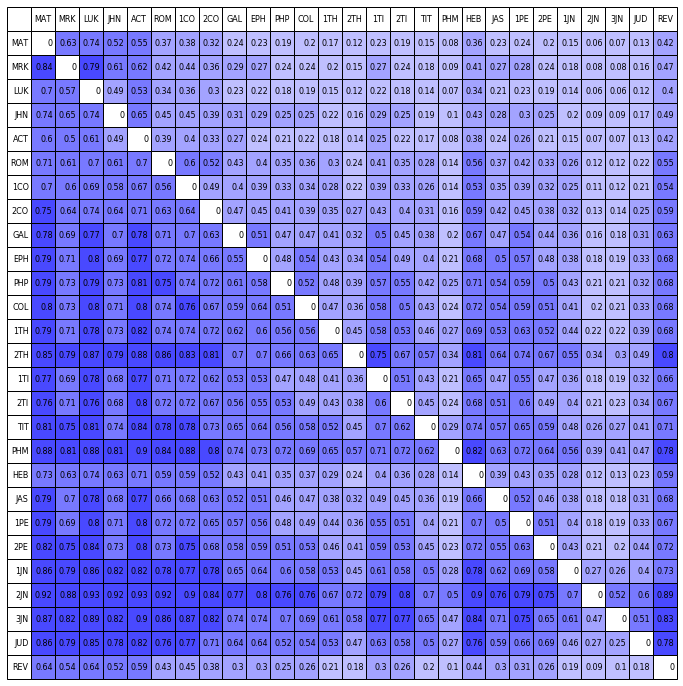

gaddi


Ploting single word counts : gaddi
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

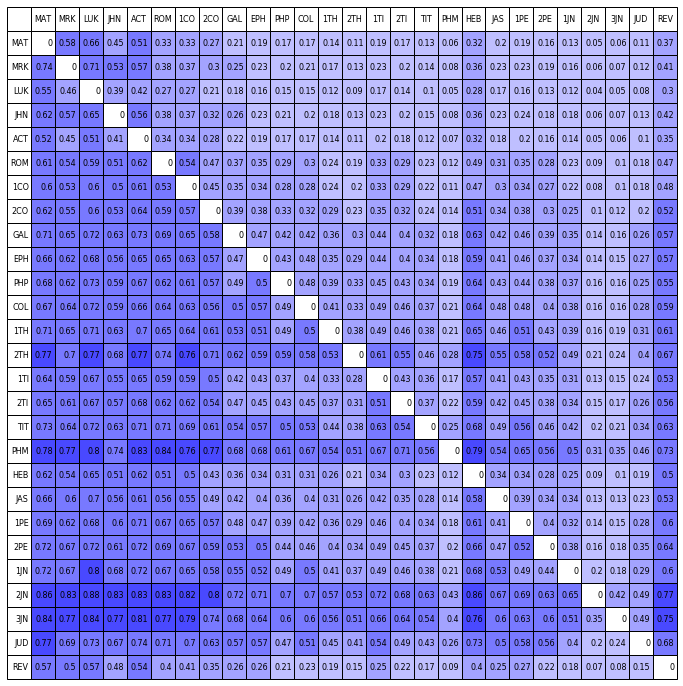

bhadrawahi


Ploting single word counts : bhadrawahi
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

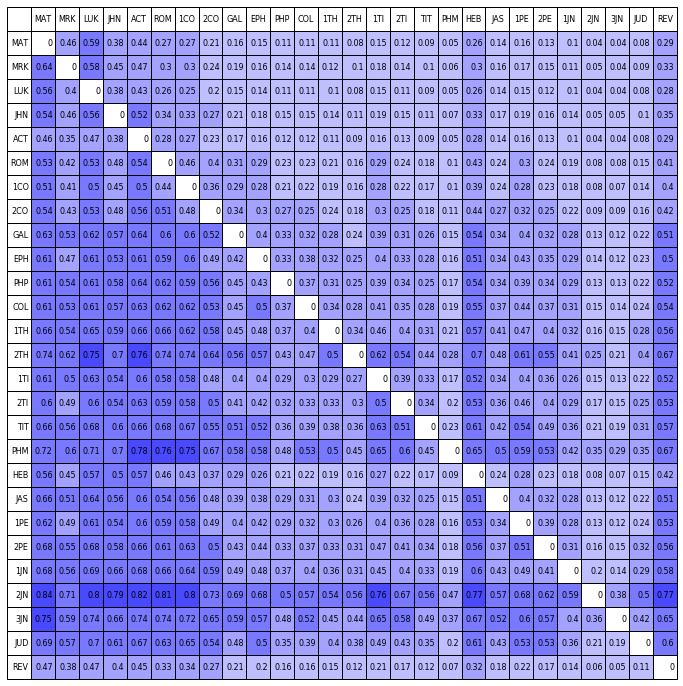

bilaspuri


Ploting single word counts : bilaspuri
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

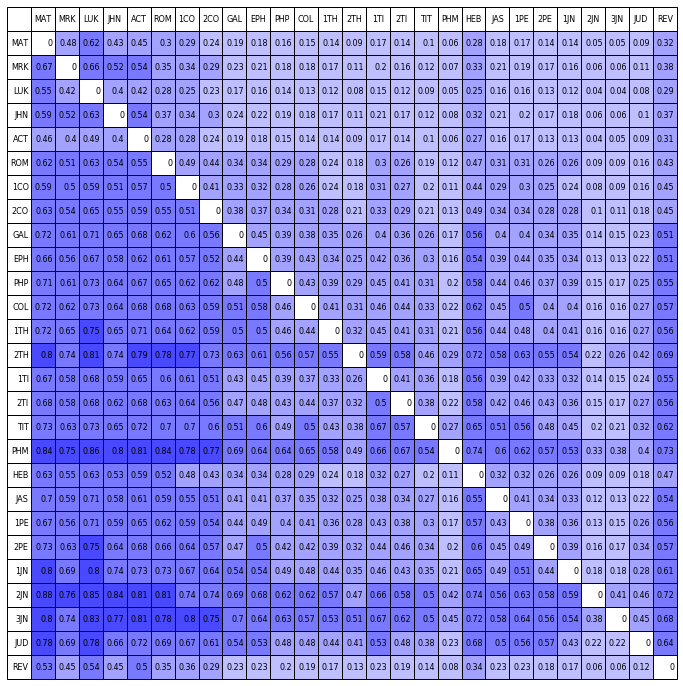

kulvi


Ploting single word counts : kulvi
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

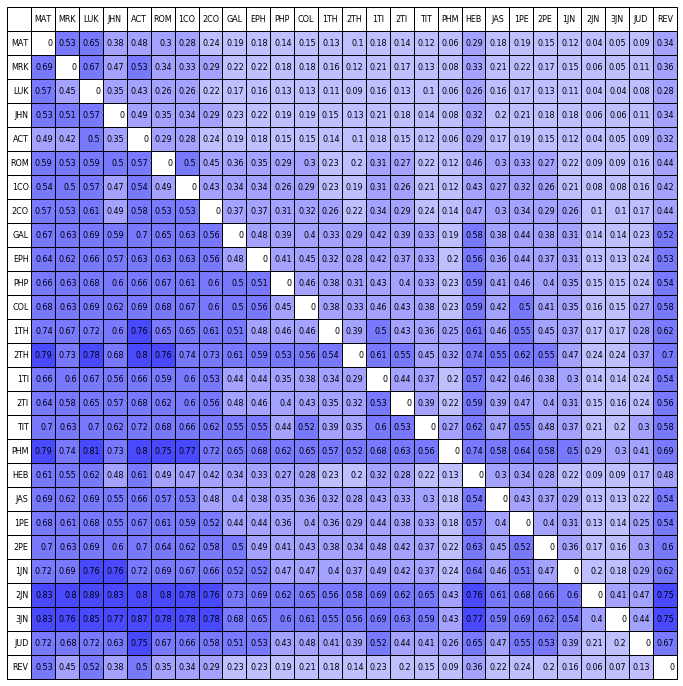

kangri


Ploting single word counts : kangri
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

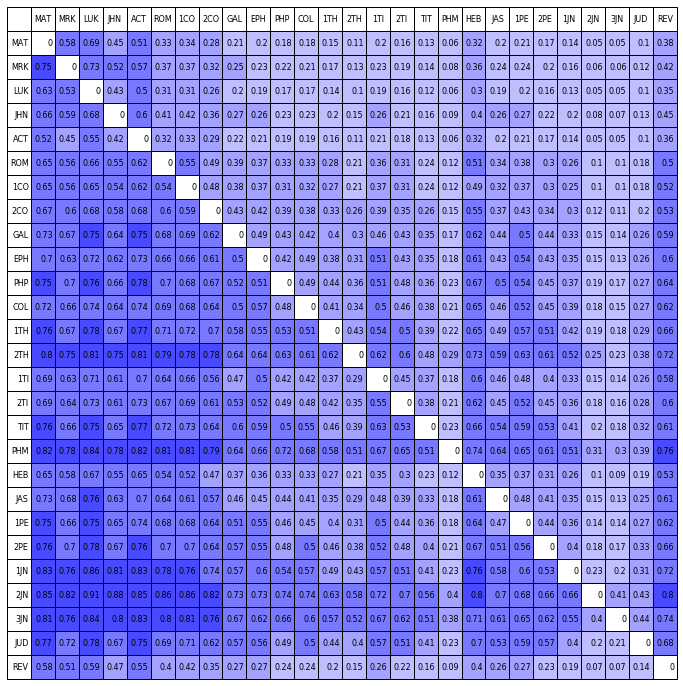

<Figure size 432x288 with 0 Axes>

In [10]:
for min_lang in min_languages:
    print(min_lang)
    rows = plot_single_words(min_lang, minority_path)
#     plot_3_grams(min_lang, minority_path)

### Analyzing top overlappings 

- Finding most common overlappings
- For each book in a language found the top 5 groupings. Similarly found top groups for all languages. Among the groups filtered out most common overlappings

In [43]:
# def analyze_overlappings(rows):
#     data = []
#     for i,x in enumerate(rows):
#         for j,y in enumerate(x):
#             if j == 0:
#                 x_book = y
#                 continue
#             y_book = book_names[j-1]    
#             data.append([(x_book, y_book), y])  
#     common_groups = sorted(data, key=lambda i: i[1], reverse=True)
#     for i,item in enumerate(common_groups):
#         print(item[0], '-->', item[1]) 
#         if i == 4:
#             break

In [11]:
def analyze_overlappings(rows):
    groups = []
    for i,x in enumerate(rows):
        temp = {}
        for j,y in enumerate(x):
            if j == 0:
                continue
            else:
                x_book = rows[j-1][0]
            temp[x_book] = y 
        temp = {k: v for k, v in sorted(temp.items(), key=lambda item: item[1], reverse=True)}
        count = 0
        for key, value in temp.items():
            if count == 5:
                break
            groups.append(((x[0], key), value))
            count += 1    
    return groups

In [15]:
def find_common_overlaps(lang_groups):
    common_groups = sorted(Counter(lang_groups).items(), key=lambda i: i[1], reverse=True) 
    common_groups = [[list(item[0]), item[1]]for item in common_groups]
#     for item in common_groups:
#         print(list(item))

    out = []
    processed = []
    for i,entry in enumerate(common_groups): 
        if i in processed:
            continue
        percent = float(entry[0][1])
        num = 1
        count = entry[1]
        for j,item in enumerate(common_groups):
            if entry == item:
                continue
            if(entry[0][0] == item[0][0]):
                count += item[1]
                percent += float(item[0][1])
                num += 1
                processed.append(j)

        out.append([[entry[0][0], round(percent/num, 2)], count])
        
    values = set(map(lambda x:x[1], out))
    values = sorted(list(values), reverse=True)
    newlist = [[[y[0], y[1]] for y in out if y[1]==x] for x in values]
    for group in newlist:
        print("\n\n-----------------------   count : ", group[0][1])
        group = [entry[0] for entry in group]
        group = sorted(group ,  key=lambda i: i[1], reverse=True)
        print(group)    



lang :  mandeali


Ploting single word counts : mandeali
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


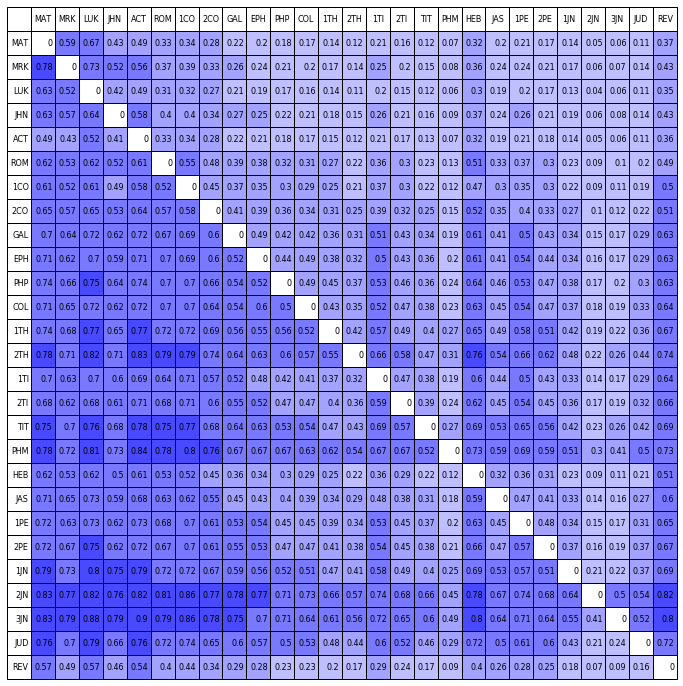



lang :  haryanvi


Ploting single word counts : haryanvi
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

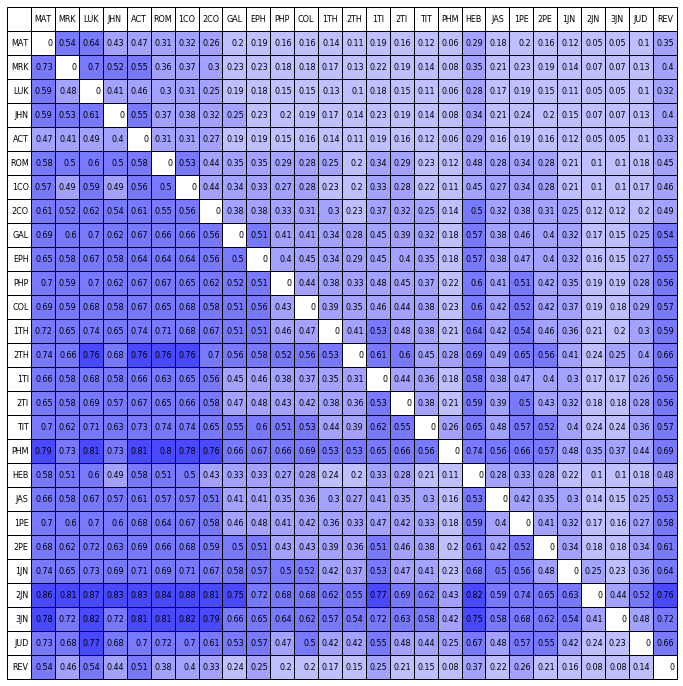



lang :  dogri


Ploting single word counts : dogri
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

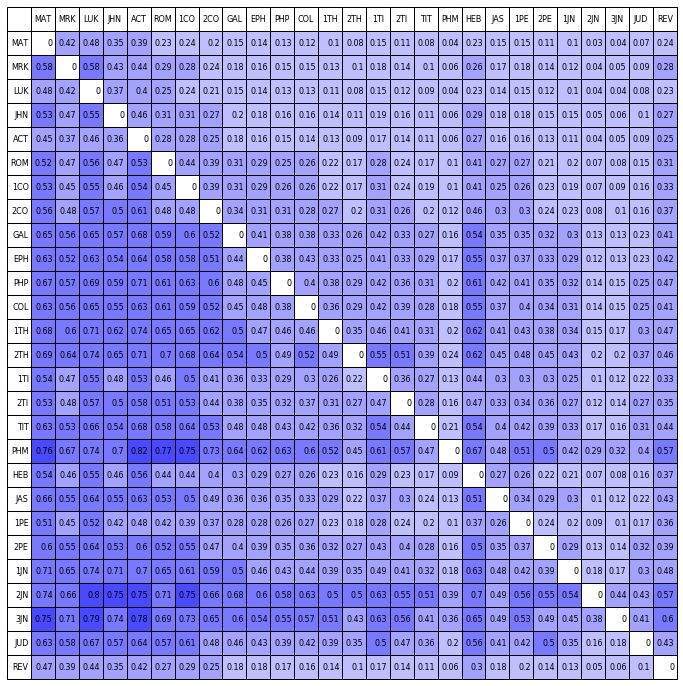



lang :  pahari_mahasui


Ploting single word counts : pahari_mahasui
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

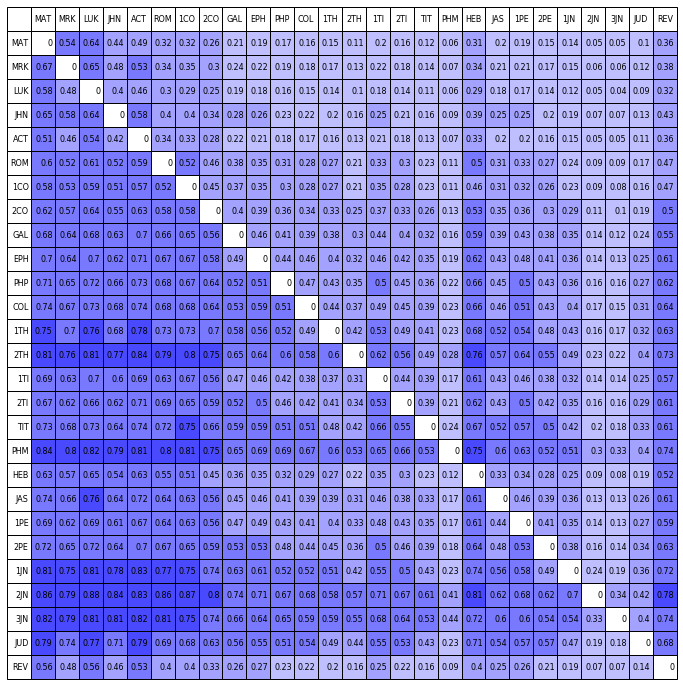



lang :  baghlayani


Ploting single word counts : baghlayani
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

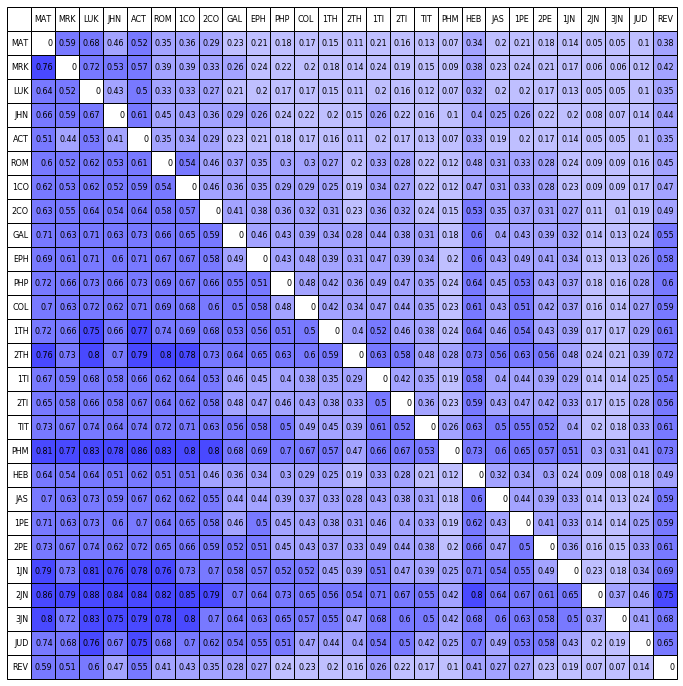



lang :  chambeali


Ploting single word counts : chambeali
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

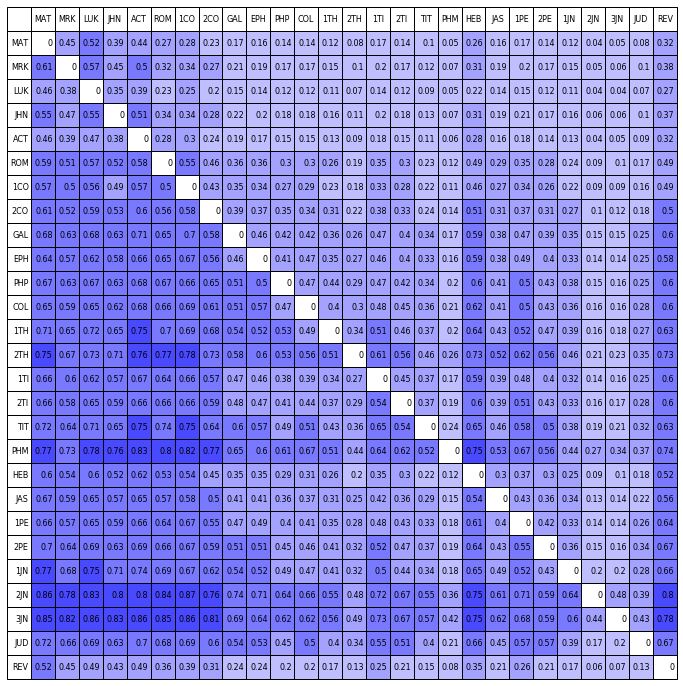



lang :  kulvi_outer_seraji


Ploting single word counts : kulvi_outer_seraji
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

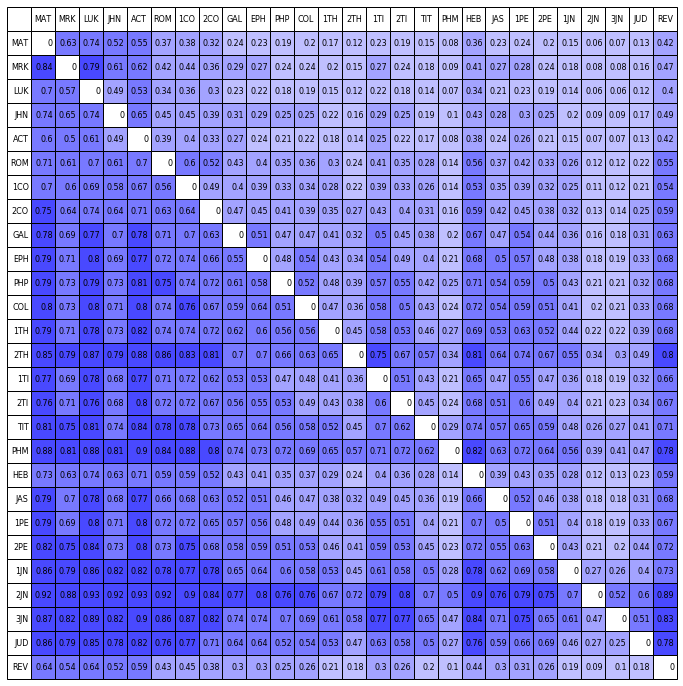



lang :  gaddi


Ploting single word counts : gaddi
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

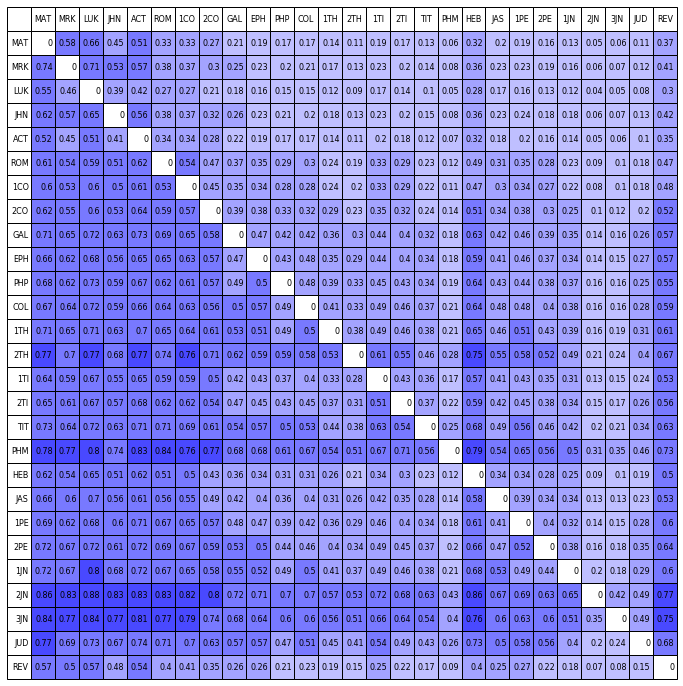



lang :  bhadrawahi


Ploting single word counts : bhadrawahi
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

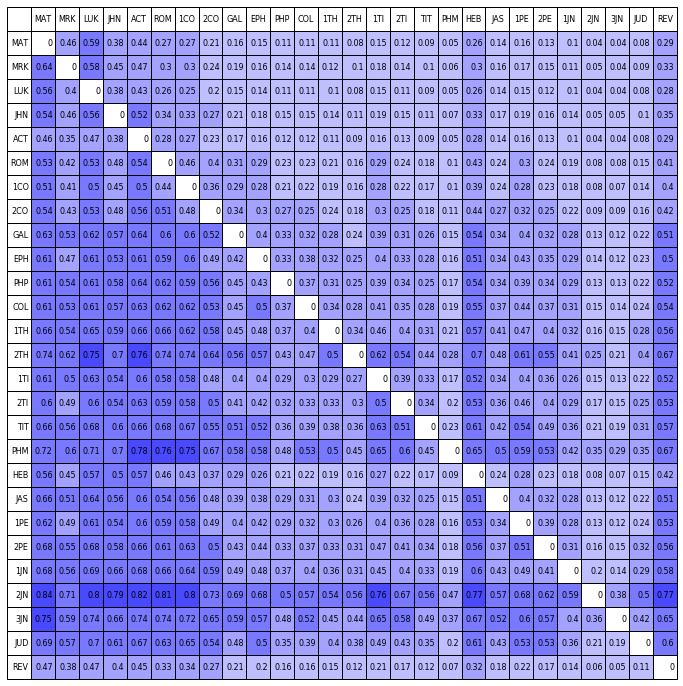



lang :  bilaspuri


Ploting single word counts : bilaspuri
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

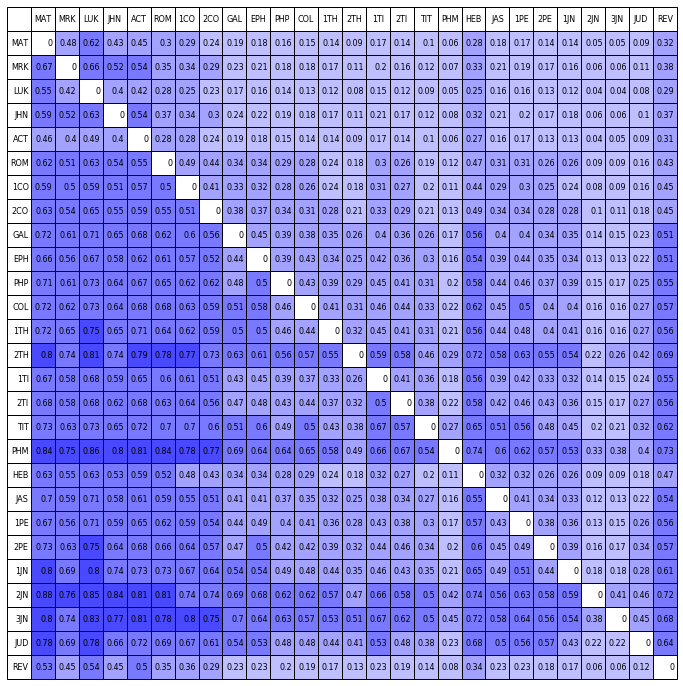



lang :  kulvi


Ploting single word counts : kulvi
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

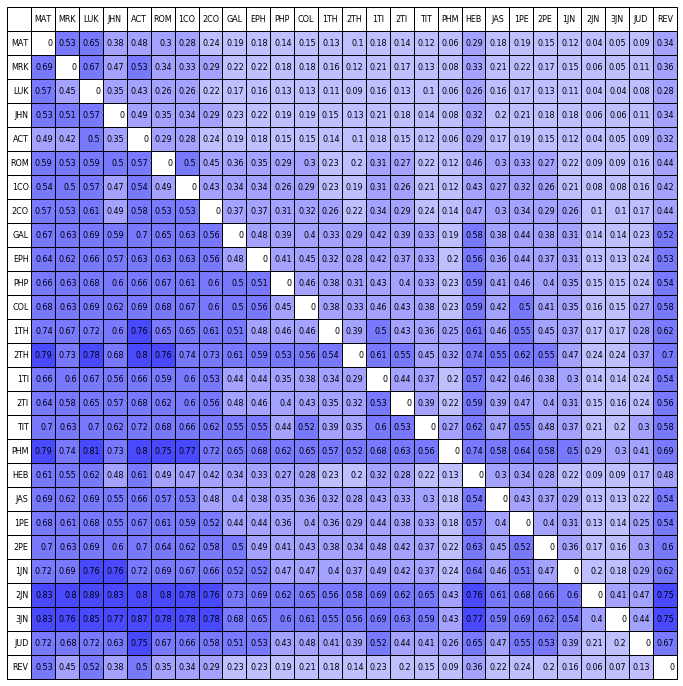



lang :  kangri


Ploting single word counts : kangri
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

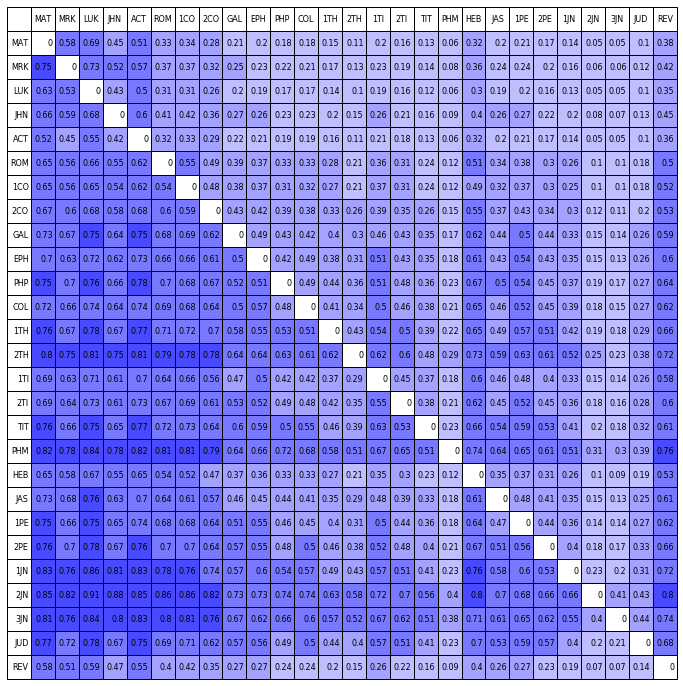

<Figure size 432x288 with 0 Axes>

In [13]:
lang_groups = []
for min_lang in min_languages:
    print("\n\nlang : ",min_lang)
    rows = plot_single_words(min_lang, minority_path)
    lang_groups += analyze_overlappings(rows)

In [16]:
find_common_overlaps(lang_groups)



-----------------------   count :  12
[[('2JN', 'LUK'), 0.86], [('2JN', 'MAT'), 0.85], [('PHM', 'ACT'), 0.83], [('3JN', 'LUK'), 0.83], [('3JN', 'ACT'), 0.82], [('PHM', 'LUK'), 0.81], [('2TH', 'ACT'), 0.8], [('PHM', 'MAT'), 0.8], [('2TH', 'LUK'), 0.78], [('1JN', 'LUK'), 0.77], [('2TH', '1CO'), 0.77], [('1JN', 'MAT'), 0.77], [('2TH', 'MAT'), 0.77], [('JUD', 'LUK'), 0.75], [('1JN', 'ACT'), 0.75], [('JUD', 'MAT'), 0.75], [('1TH', 'ACT'), 0.74], [('1JN', 'JHN'), 0.74], [('TIT', 'ACT'), 0.74], [('1TH', 'MAT'), 0.73], [('2PE', 'LUK'), 0.73], [('JUD', 'ACT'), 0.73], [('TIT', 'LUK'), 0.73], [('1TH', 'LUK'), 0.73], [('TIT', 'MAT'), 0.72], [('2PE', 'MAT'), 0.72], [('JAS', 'MAT'), 0.71], [('PHP', 'ACT'), 0.71], [('TIT', 'ROM'), 0.71], [('PHP', 'LUK'), 0.71], [('GAL', 'ACT'), 0.71], [('MRK', 'MAT'), 0.71], [('TIT', '1CO'), 0.71], [('COL', 'LUK'), 0.7], [('2PE', 'ACT'), 0.7], [('GAL', 'LUK'), 0.7], [('JAS', 'LUK'), 0.7], [('PHP', 'MAT'), 0.7], [('COL', 'ACT'), 0.7], [('GAL', 'MAT'), 0.7], [('COL',

## gl 

- Analyzing gl to find common overlappings



Ploting single word counts : hindi
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


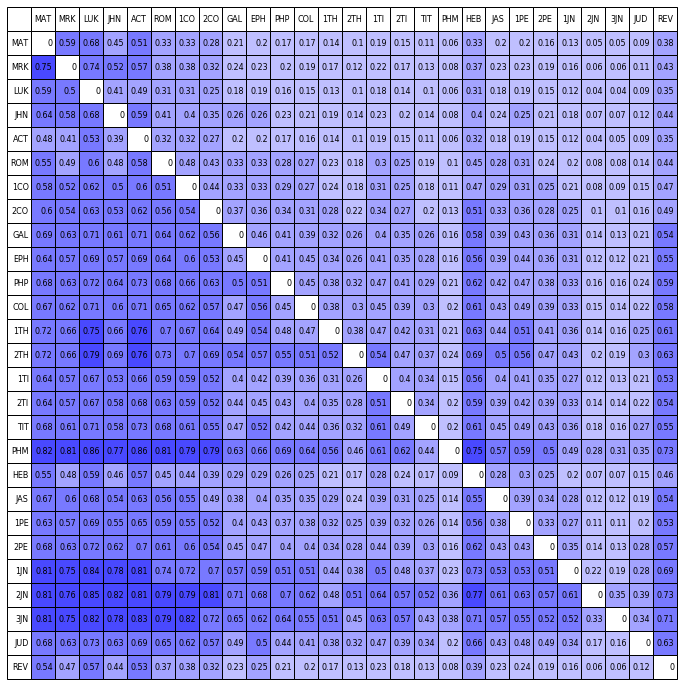



Ploting single word counts : malayalam
color_groups : 
 {'0-0.25': '#BFBFFF', '0.25-0.5': '#A3A3FF', '0.5-0.75': '#7879FF', '0.75-1.0': '#4949FF'}


<Figure size 432x288 with 0 Axes>

In [ ]:
lang_groups = []
temp_languges = ['hindi', 'malayalam', 'tamil']
for lang in temp_languges:
    rows = plot_single_words(lang, gl_path)
    lang_groups += analyze_overlappings(rows)

In [18]:
find_common_overlaps(lang_groups)



-----------------------   count :  1
[[('PHM', 'MAT'), 0.82], [('PHM', 'MRK'), 0.81], [('3JN', 'ROM'), 0.79], [('1JN', 'MRK'), 0.75], [('PHP', 'MAT'), 0.68], [('JUD', 'HEB'), 0.66], [('JUD', 'ROM'), 0.65], [('GAL', 'MRK'), 0.63], [('2PE', 'MRK'), 0.63], [('COL', 'MRK'), 0.62], [('TIT', 'MRK'), 0.61], [('1TI', '1CO'), 0.59], [('2TI', '1CO'), 0.59], [('1PE', 'MRK'), 0.57], [('2CO', 'MRK'), 0.54], [('1CO', 'MRK'), 0.52], [('ROM', 'MRK'), 0.49], [('PHM', '1CO'), 0.42], [('2JN', '1CO'), 0.41], [('2JN', 'MRK'), 0.41], [('PHM', 'JHN'), 0.39], [('3JN', 'MRK'), 0.38], [('2TH', '2CO'), 0.32], [('1TH', 'JHN'), 0.31], [('PHP', 'JHN'), 0.31], [('TIT', 'JHN'), 0.26], [('2PE', 'HEB'), 0.25], [('TIT', '1TI'), 0.23], [('1TI', 'JHN'), 0.22], [('1TI', 'MRK'), 0.22], [('HEB', 'ROM'), 0.19], [('JHN', 'ROM'), 0.16]]


-----------------------   count :  2
[[('2JN', 'LUK'), 0.65], [('2JN', 'ACT'), 0.65], [('2JN', 'MAT'), 0.62], [('2JN', '2CO'), 0.61], [('3JN', 'MAT'), 0.61], [('2TH', '1CO'), 0.52], [('1TH',